In [208]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### **1. DATA LOADING AND SETUP**

In [209]:
df = pd.read_csv('data/players_20.csv')

In [210]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18278 entries, 0 to 18277
Columns: 104 entries, sofifa_id to rb
dtypes: float64(16), int64(45), object(43)
memory usage: 14.5+ MB


In [211]:
for column in df.columns:
    num_missing = df[column].isnull().sum()
    if num_missing > 0:
        print(f"Column '{column}' has {num_missing} missing values.")

Column 'release_clause_eur' has 1298 missing values.
Column 'player_tags' has 16779 missing values.
Column 'team_position' has 240 missing values.
Column 'team_jersey_number' has 240 missing values.
Column 'loaned_from' has 17230 missing values.
Column 'joined' has 1288 missing values.
Column 'contract_valid_until' has 240 missing values.
Column 'nation_position' has 17152 missing values.
Column 'nation_jersey_number' has 17152 missing values.
Column 'pace' has 2036 missing values.
Column 'shooting' has 2036 missing values.
Column 'passing' has 2036 missing values.
Column 'dribbling' has 2036 missing values.
Column 'defending' has 2036 missing values.
Column 'physic' has 2036 missing values.
Column 'gk_diving' has 16242 missing values.
Column 'gk_handling' has 16242 missing values.
Column 'gk_kicking' has 16242 missing values.
Column 'gk_reflexes' has 16242 missing values.
Column 'gk_speed' has 16242 missing values.
Column 'gk_positioning' has 16242 missing values.
Column 'player_trait

*player_tags*, *position* and *jersey number* give a kind of obvious idea of the position played by the player. I intend to cluster classify these players based on their playing attributes like speed, passing, shooting, dribbling abilities etc.

things like club being played for, club loaned or bought from are out of the question. So I will limit my exploration to the following columns:

    - those that include phisicali/body
    - attacking/defensive/technical abilities
    - mental/tactical/movement

In [212]:
features = [
    # keeping player positions for filtering later (won't be used to train)
    # "player_positions",

    # Physical / Body
    "age",
    "height_cm",
    "weight_kg",

    # Aggregate Outfield Attributes
    "pace",
    "shooting",
    "passing",
    "dribbling",
    "defending",
    "physic",

    # Attacking
    "attacking_crossing",
    "attacking_finishing",
    "attacking_heading_accuracy",
    "attacking_short_passing",
    "attacking_volleys",

    # Technical Skills
    "skill_dribbling",
    "skill_curve",
    "skill_fk_accuracy",
    "skill_long_passing",
    "skill_ball_control",

    # Movement
    "movement_acceleration",
    "movement_sprint_speed",
    "movement_agility",
    "movement_reactions",
    "movement_balance",

    # Power / Physicality
    "power_shot_power",
    "power_jumping",
    "power_stamina",
    "power_strength",
    "power_long_shots",

    # Mental / Tactical
    "mentality_aggression",
    "mentality_interceptions",
    "mentality_positioning",
    "mentality_vision",
    "mentality_penalties",
    "mentality_composure",

    # Defensive
    "defending_marking",
    "defending_standing_tackle",
    "defending_sliding_tackle",

    # Goalkeeping
    "goalkeeping_diving",
    "goalkeeping_handling",
    "goalkeeping_kicking",
    "goalkeeping_positioning",
    "goalkeeping_reflexes"
]

In [213]:
data = df[features]
for column in data.columns:
    num_missing = data[column].isnull().sum()
    if num_missing > 0:
        print(f"Column '{column}' has {num_missing} missing values.")
data.head()

Column 'pace' has 2036 missing values.
Column 'shooting' has 2036 missing values.
Column 'passing' has 2036 missing values.
Column 'dribbling' has 2036 missing values.
Column 'defending' has 2036 missing values.
Column 'physic' has 2036 missing values.


,age,height_cm,weight_kg,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,32,170,72,87.0,92.0,92.0,96.0,39.0,66.0,88,...,75,96,33,37,26,6,11,15,14,8
1,34,187,83,90.0,93.0,82.0,89.0,35.0,78.0,84,...,85,95,28,32,24,7,11,15,14,11
2,27,175,68,91.0,85.0,87.0,95.0,32.0,58.0,87,...,90,94,27,26,29,9,9,15,15,11
3,26,188,87,NaN,NaN,NaN,NaN,NaN,NaN,13,...,11,68,27,12,18,87,92,78,90,89
4,28,175,74,91.0,83.0,86.0,94.0,35.0,66.0,81,...,88,91,34,27,22,11,12,6,8,8


In [214]:
# to see how many records I have (for dealing with the missing data):
data.shape

(18278, 43)

In [215]:
# using imputation for missing outfield attributes for goalkeepers
# data.fillna(data.mean(), inplace=True)

outfield_cols = ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']

# Fill NaNs with random values between 5 and 25 (Realistic for GKs)
for col in outfield_cols:
    # Find rows where this column is missing
    missing_mask = data[col].isnull()
    num_missing = missing_mask.sum()
    
    if num_missing > 0:
        # Generate random integers between 5 and 25
        random_values = np.random.randint(5, 25, size=num_missing)
        # Assign them
        data.loc[missing_mask, col] = random_values

# Fill the remaining columns (like goalkeeping stats for outfielders) with 0
data.fillna(0, inplace=True)

/tmp/ipykernel_15049/4112480931.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.fillna(0, inplace=True)


In [216]:
data.shape

(18278, 43)

In [217]:
for column in data.columns:
    num_missing = data[column].isnull().sum()
    if num_missing > 0:
        print(f"Column '{column}' has {num_missing} missing values.")

### **2. EXPLORATORY DATA ANALYSIS**

In [218]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,18278.0,25.283291,4.656964,16.0,22.0,25.0,29.0,42.0
height_cm,18278.0,181.362184,6.756961,156.0,177.0,181.0,186.0,205.0
weight_kg,18278.0,75.276343,7.047744,50.0,70.0,75.0,80.0,110.0
pace,18278.0,61.772021,19.941929,5.0,57.0,67.0,74.0,96.0
shooting,18278.0,48.079877,17.902540,5.0,35.0,52.0,62.0,93.0
passing,18278.0,52.467174,16.771533,5.0,46.0,56.0,63.0,92.0
dribbling,18278.0,57.172229,18.081966,5.0,53.0,62.0,69.0,96.0
defending,18278.0,47.420451,19.482350,5.0,31.0,52.0,64.0,90.0
physic,18278.0,59.269559,18.415637,5.0,55.0,64.0,71.0,90.0
attacking_crossing,18278.0,49.718405,18.325403,5.0,38.0,54.0,64.0,93.0


Visualizing distributions for outfield players' attributes

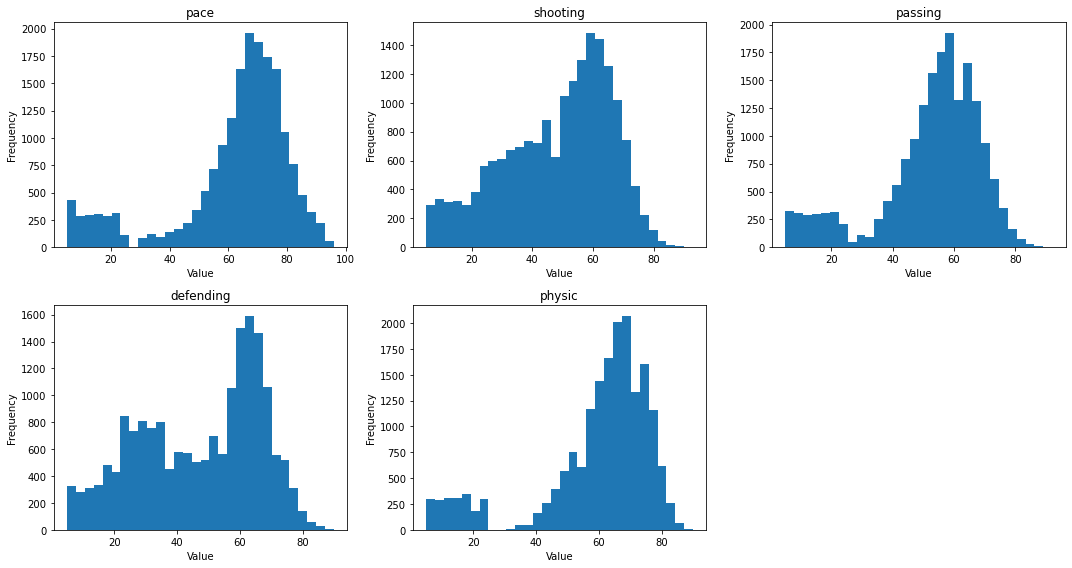

In [219]:
key_features = ["pace", "shooting", "passing", "defending", "physic"]

plt.figure(figsize=(15, 8))

for i, col in enumerate(key_features, 1):
    plt.subplot(2, 3, i)
    plt.hist(data[col].values, bins=30)
    plt.title(col)
    plt.xlabel("Value")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


Visualizing distributions for key goalkeeping attributes

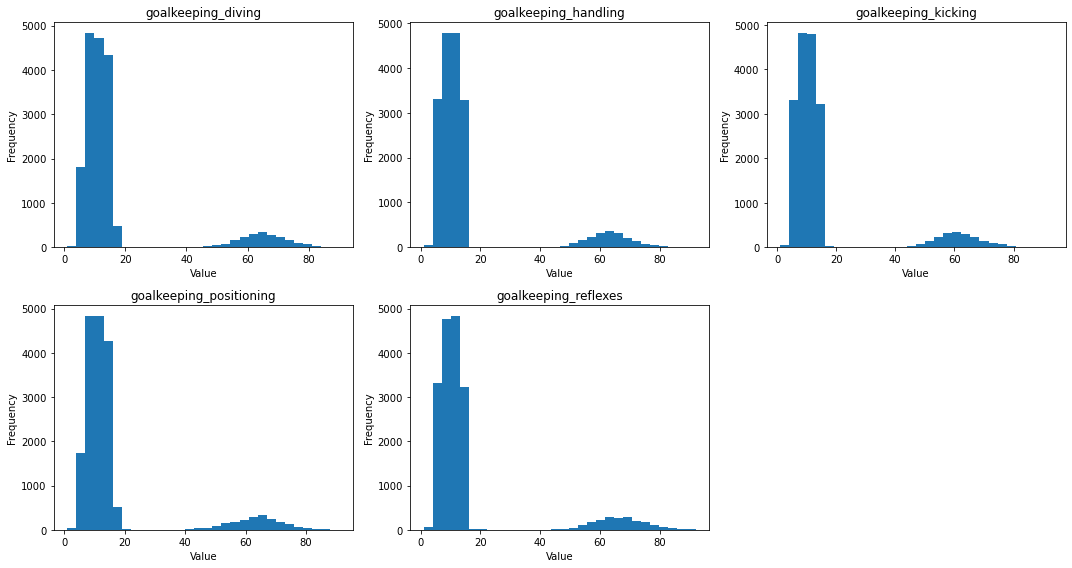

In [220]:
gk_features = [
    "goalkeeping_diving",
    "goalkeeping_handling",
    "goalkeeping_kicking",
    "goalkeeping_positioning",
    "goalkeeping_reflexes"
]

plt.figure(figsize=(15, 8))

for i, col in enumerate(gk_features, 1):
    plt.subplot(2, 3, i)
    plt.hist(data[col].values, bins=30)
    plt.title(col)
    plt.xlabel("Value")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

It makes sense that the distributions show some trend from 0-20, and then another somehow normally distributed around 50-90. 

Those from 0-20 show the ratings for outfield players in goalkeeping positions wchich is quite expected.

That being the case, it is expected that the precision and recall for the cluster with GK to be higher.

In [221]:
# data = data[data['player_positions'] != 'GK']
# data.drop(columns=['player_positions'], inplace=True)
data.head()

,age,height_cm,weight_kg,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,32,170,72,87.0,92.0,92.0,96.0,39.0,66.0,88,...,75,96,33,37,26,6,11,15,14,8
1,34,187,83,90.0,93.0,82.0,89.0,35.0,78.0,84,...,85,95,28,32,24,7,11,15,14,11
2,27,175,68,91.0,85.0,87.0,95.0,32.0,58.0,87,...,90,94,27,26,29,9,9,15,15,11
3,26,188,87,19.0,12.0,8.0,9.0,19.0,21.0,13,...,11,68,27,12,18,87,92,78,90,89
4,28,175,74,91.0,83.0,86.0,94.0,35.0,66.0,81,...,88,91,34,27,22,11,12,6,8,8


### **3. DATA PREPOCESSING**

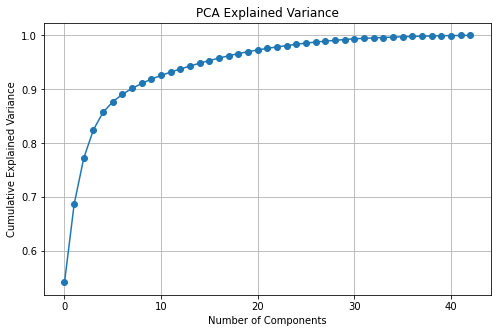

In [222]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid()
plt.show()


The explained variance curve proves the attributes are not random, it shows the data has a particular structure 

It has also justified dimensionality reduction as ~85% variance explained by ~10 components”

In [223]:
X_pca.shape

(18278, 43)

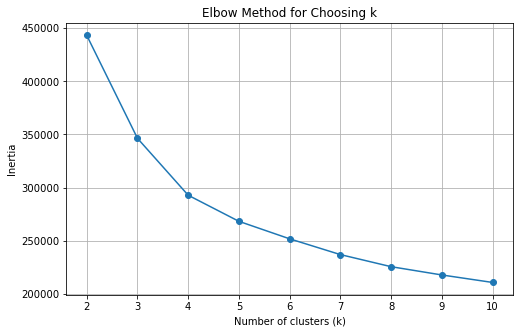

In [224]:
from sklearn.cluster import KMeans

inertia = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Choosing k")
plt.grid(True)
plt.show()

Choosing K=4 based on domain knowledge and support from the elbow graph

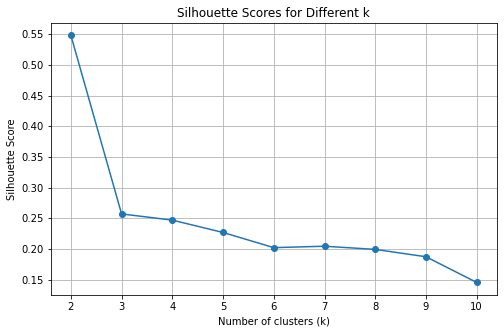

In [225]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Different k")
plt.grid(True)
plt.show()

Silhouette analysis indicated the highest score at k = 2, suggesting a strong separation between goalkeepers and outfield players. 

However, given the objective of identifying four primary playing roles, k = 4 was selected. 

The reduced silhouette score at k = 4 reflects the known overlap between outfield positions, which is consistent with football **domain knowledge**.

### **4. MODEL TRAINING**

In [226]:
from sklearn.cluster import KMeans

k = 4

kmeans = KMeans(
    n_clusters=k,
    random_state=42,
    n_init=10
)

cluster_labels = kmeans.fit_predict(X_scaled)

In [227]:
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
cluster_counts

0    5496
1    2036
2    5685
3    5061
Name: count, dtype: int64

In [228]:
data_clustered = data.copy()
data_clustered["cluster"] = cluster_labels

In [229]:
data_clustered.head()

,age,height_cm,weight_kg,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,...,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,cluster
0,32,170,72,87.0,92.0,92.0,96.0,39.0,66.0,88,...,96,33,37,26,6,11,15,14,8,2
1,34,187,83,90.0,93.0,82.0,89.0,35.0,78.0,84,...,95,28,32,24,7,11,15,14,11,2
2,27,175,68,91.0,85.0,87.0,95.0,32.0,58.0,87,...,94,27,26,29,9,9,15,15,11,2
3,26,188,87,19.0,12.0,8.0,9.0,19.0,21.0,13,...,68,27,12,18,87,92,78,90,89,1
4,28,175,74,91.0,83.0,86.0,94.0,35.0,66.0,81,...,91,34,27,22,11,12,6,8,8,2


In [230]:
profile_features = [
    "pace", "shooting", "passing", "defending", "physic",
    "goalkeeping_diving", "goalkeeping_reflexes"
]

data_clustered.groupby("cluster")[profile_features].mean()

,pace,shooting,passing,defending,physic,goalkeeping_diving,goalkeeping_reflexes
cluster,,,,,,,
0,72.080968,58.752911,55.362263,33.155022,57.622089,10.335153,10.405204
1,14.474951,14.427800,14.442043,14.449411,14.539293,65.422397,66.390472
2,69.400704,60.622691,66.630783,60.103254,69.562709,10.630607,10.651363
3,61.034973,35.938155,48.710532,61.929461,67.491010,10.369492,10.376013


### **5. VISUALIZING THE CLUSTERS**

/tmp/ipykernel_15049/4010463127.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['GK_Skill'] = data[gk_cols].mean(axis=1)
/tmp/ipykernel_15049/4010463127.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Offensive_Skill'] = (data['shooting'] + data['passing'] + data['dribbling']) / 3
/tmp/ipykernel_15049/4010463127.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

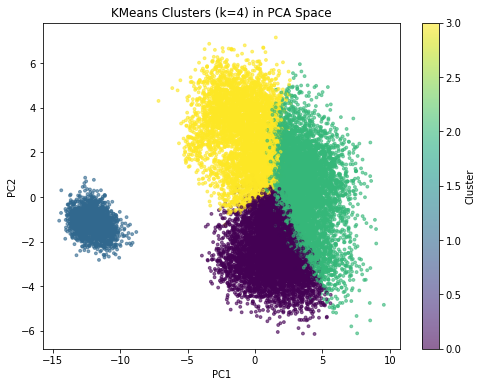

In [231]:
gk_cols = ['goalkeeping_diving', 'goalkeeping_reflexes', 'goalkeeping_handling', 'goalkeeping_positioning']
data['GK_Skill'] = data[gk_cols].mean(axis=1)
data['Offensive_Skill'] = (data['shooting'] + data['passing'] + data['dribbling']) / 3
data['Defensive_Physicality'] = (data['defending'] + data['physic']) / 2

plt.figure(figsize=(8, 6))
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=cluster_labels,
    s=8,
    alpha=0.6
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("KMeans Clusters (k=4) in PCA Space")
plt.colorbar(label="Cluster")
plt.show()

#### **5.1 Visualizing using a Bubble Chart**

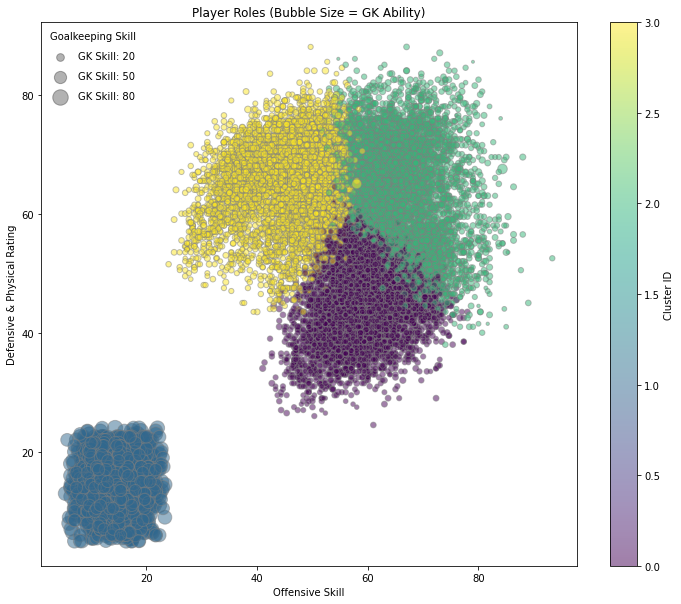

In [232]:
# We scale GK skill so the bubbles are visible (e.g., skill * 3)
bubble_size = data['GK_Skill'] * 3 

plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    data['Offensive_Skill'], 
    data['Defensive_Physicality'], 
    c=cluster_labels, 
    cmap='viridis',
    s=bubble_size,  # Size corresponds to GK stats
    alpha=0.5,
    edgecolors='gray' # Adds a border so overlapping bubbles are distinct
)

plt.xlabel("Offensive Skill")
plt.ylabel("Defensive & Physical Rating")
plt.title("Player Roles (Bubble Size = GK Ability)")

# Legend hack to explain bubble size
# We create dummy points to make a legend
for area in [20, 50, 80]:
    plt.scatter([], [], c='k', alpha=0.3, s=area*3, label=f'GK Skill: {area}')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Goalkeeping Skill')

plt.colorbar(scatter, label="Cluster ID")
plt.show()

#### **5.2 Visualizing in 3D**

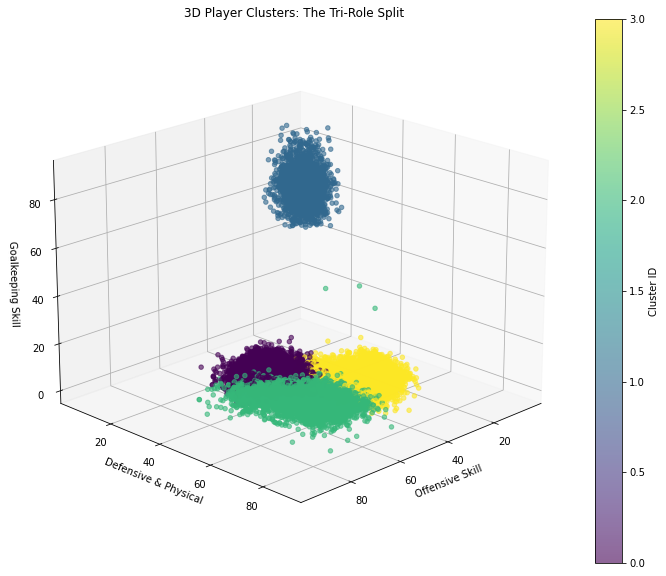

In [233]:
from mpl_toolkits.mplot3d import Axes3D

# 1. Create the 3rd Dimension: Goalkeeping Skill
# We average the key GK stats

# 2. Setup 3D Plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# 3. Plot
scatter = ax.scatter(
    data['Offensive_Skill'],       # X Axis
    data['Defensive_Physicality'], # Y Axis
    data['GK_Skill'],              # Z Axis (Height)
    c=cluster_labels,              # Color by cluster
    cmap='viridis',
    s=20,
    alpha=0.6
)

# 4. Labels and View
ax.set_xlabel('Offensive Skill')
ax.set_ylabel('Defensive & Physical')
ax.set_zlabel('Goalkeeping Skill')
ax.set_title('3D Player Clusters: The Tri-Role Split')

# Adjust the viewing angle to see the separation best
# elev=20 (height), azim=45 (rotation)
ax.view_init(elev=20, azim=45)

plt.colorbar(scatter, label="Cluster ID")
plt.show()

### **6. RETURNING THE POSITIONS FOR EVALUATION**

In [234]:
data_clustered['real_position'] = df['player_positions']
data_clustered['short_name'] = df['short_name']

In [235]:
data_clustered.head()

,age,height_cm,weight_kg,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,...,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,cluster,real_position,short_name
0,32,170,72,87.0,92.0,92.0,96.0,39.0,66.0,88,...,37,26,6,11,15,14,8,2,"RW, CF, ST",L. Messi
1,34,187,83,90.0,93.0,82.0,89.0,35.0,78.0,84,...,32,24,7,11,15,14,11,2,"ST, LW",Cristiano Ronaldo
2,27,175,68,91.0,85.0,87.0,95.0,32.0,58.0,87,...,26,29,9,9,15,15,11,2,"LW, CAM",Neymar Jr
3,26,188,87,19.0,12.0,8.0,9.0,19.0,21.0,13,...,12,18,87,92,78,90,89,1,GK,J. Oblak
4,28,175,74,91.0,83.0,86.0,94.0,35.0,66.0,81,...,27,22,11,12,6,8,8,2,"LW, CF",E. Hazard


In [236]:
# 2. Simplify Positions (FIFA has 15+ positions, we group them)
def simplify_position(pos):
    if isinstance(pos, str):
        main_pos = pos.split(',')[0] # Take the first position listed
        if main_pos in ['GK']: return 'Goalkeeper'
        if main_pos in ['CB', 'LB', 'RB', 'LWB', 'RWB']: return 'Defender'
        if main_pos in ['CDM', 'CM', 'CAM', 'RM', 'LM']: return 'Midfielder'
        if main_pos in ['ST', 'CF', 'RW', 'LW']: return 'Attacker'
    return 'Unknown'

data_clustered['simple_role'] = data_clustered['real_position'].apply(simplify_position)

# 3. The "Truth Table"
print(pd.crosstab(data_clustered['cluster'], data_clustered['simple_role']))

simple_role  Attacker  Defender  Goalkeeper  Midfielder
cluster                                                
0                2709        97           0        2690
1                   0         0        2036           0
2                 708      1698           0        3279
3                  25      4143           0         893


In [237]:
# Find the player closest to the center of each cluster
from sklearn.metrics import pairwise_distances_argmin_min

# Get the coordinates of each cluster center
centroids = kmeans.cluster_centers_

# Find the index of the player closest to each centroid
closest_indices, _ = pairwise_distances_argmin_min(centroids, X_scaled)

print("The Archetype Players (The perfect example of each role):")
for i, idx in enumerate(closest_indices):
    player_name = data_clustered.iloc[idx]['short_name']
    print(f"Cluster {i}: {player_name}")

The Archetype Players (The perfect example of each role):
Cluster 0: J. Medina
Cluster 1: N. Avellaneda
Cluster 2: S. Branca
Cluster 3: J. McGing


In [ ]:
def recommend_replacement(player_name, data, n_recommendations=5):
    # 1. Find the player's stats
    target = data[data['short_name'] == player_name]
    if target.empty: return "Player not found."
    
    target_cluster = target['cluster'].values[0]
    
    # 2. Filter to players in the SAME cluster (narrow the search)
    cluster_mates = data[data['cluster'] == target_cluster]
    
    # 3. Calculate distance to all other players in that cluster
    # (Using the numeric features only)
    numeric_cols = ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic'] 
    
    # Simple Euclidean distance
    distances = np.linalg.norm(cluster_mates[numeric_cols].values - target[numeric_cols].values, axis=1)
    
    # 4. Get the closest matches
    cluster_mates = cluster_mates.copy()
    cluster_mates['distance'] = distances
    recommendations = cluster_mates.sort_values('distance').iloc[1:n_recommendations+1] # Skip 0 (self)
    
    return recommendations[['short_name', 'distance', 'simple_role']]

# test
print(recommend_replacement("M. Reus", data_clustered, 30).T)

                  43          23           66             178         198  \
short_name     H. Son   P. Dybala  A. Di María  Marco Asensio  F. Thauvin   
distance     6.480741    7.549834     9.746794      10.630146    10.86278   
simple_role  Attacker  Midfielder     Attacker       Attacker    Attacker   

                    109         155        9              230         118  \
short_name   K. Havertz    E. Višća   M. Salah  W. Ben Yedder   J. Brandt   
distance        11.7047   11.789826  12.041595      12.288206   12.288206   
simple_role  Midfielder  Midfielder   Attacker       Attacker  Midfielder   

             ...         149          197           22           182  \
short_name   ...     Canales  Lucas Moura  A. Griezmann  Y. Carrasco   
distance     ...   14.247807    14.247807     14.282857    14.491377   
simple_role  ...  Midfielder     Attacker      Attacker   Midfielder   

                   4           301            145         328         104  \
short_name   E. 

In [244]:
import joblib

# saving Model and Scaler
joblib.dump(kmeans, 'kmeans_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

# saving Processed Data (with clusters)
data_clustered.to_csv('clustered_fifa_data.csv', index=False)

print("Model and Data saved successfully!")

Model and Data saved successfully!
